In [4]:
# pip install googletrans==4.0.0-rc1

In [2]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import pymorphy3
import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/hq-y0j97m7v06/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hq-y0j97m7v06/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hq-y0j97m7v06/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [71]:
from googletrans import Translator

def translate_text_to_eng(row) -> str:
    if row == '':
        return ''
    translator = Translator()
    translation = translator.translate(row, src='ru', dest='en')
    return translation.text

def translate_text_to_rus(row) -> str:
    if row == '':
        return ''
    translator = Translator()
    translation = translator.translate(row, src='en', dest='ru')
    return translation.text

In [3]:
def most_popular_words(row):
    row = ''.join(list(filter(lambda x: x not in r'–,.:;()[]{}\/<>-"', row)))

    # lemmatizer = WordNetLemmatizer()  # only for eng
    stemmer = SnowballStemmer("russian")  # only for rus

    tokens = word_tokenize(row)

    # lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]  # for eng
    lemmatized_words = [stemmer.stem(word) for word in tokens]  # for rus
    filtered_lemm_words = [elem for elem in lemmatized_words if len(elem) > 3]
    
    cnt = Counter(filtered_lemm_words)
    return cnt.most_common(10)

In [4]:
mine = pd.read_csv('parsed/MedDataset.csv')
print(mine.shape)
mine = mine.fillna('')
mine = mine.rename(columns={'label': 'target'})
mine['full_description'] = mine.description + ' ' + mine.category + ' ' + mine.reasons + ' ' + mine.types + ' ' + mine.symptoms + ' ' + mine.hards + ' ' + mine.diagnostics + ' ' + mine.treatment + ' ' + mine.profilactics + ' ' + mine.rehabilitations
mine['mpw'] = mine.full_description.apply(most_popular_words)
mine.head(2)

(558, 11)


,target,description,category,reasons,types,symptoms,hards,diagnostics,treatment,profilactics,rehabilitations,full_description,mpw
0,Абсцесс Броди,Абсцесс Броди — одна из форм хронического осте...,Болезни опорно-двигательной системы и травмы,Возбудители Абсцесса Броди – штаммы стафилокок...,Абсцессы могут быть асептическими и септически...,Абсцесс Броди большеберцовой кости проявляет с...,"Абсцесс Броди, как и другие формы остеомиелита...",Диагностика внутрикостного абсцесса часто затр...,"Как правило, лечение заболевания проводят в ст...",На сегодняшний день не разработано эффективных...,При консервативном лечении особых мер в рамках...,Абсцесс Броди — одна из форм хронического осте...,"[(заболеван, 15), (абсцесс, 12), (пациент, 9),..."
1,Абсцесс молочной железы,Абсцесс молочной железы – это инфекционное вос...,Заболевания молочных желез,Причины возникновения абсцесса груди следующие:,Классификация абсцессов молочной железы может ...,Как выглядит абсцесс груди – этот вопрос задаю...,Осложнения патологии проявляются в виде следую...,Диагностика заболевания предполагает:\nобщий о...,Лечение абсцесса молочной железы включает:\nан...,Прогноз при абсцессе под грудью может быть сле...,Некоторые способы профилактики субареолярного ...,Абсцесс молочной железы – это инфекционное вос...,"[(абсцесс, 19), (молочн, 17), (лечен, 16), (же..."


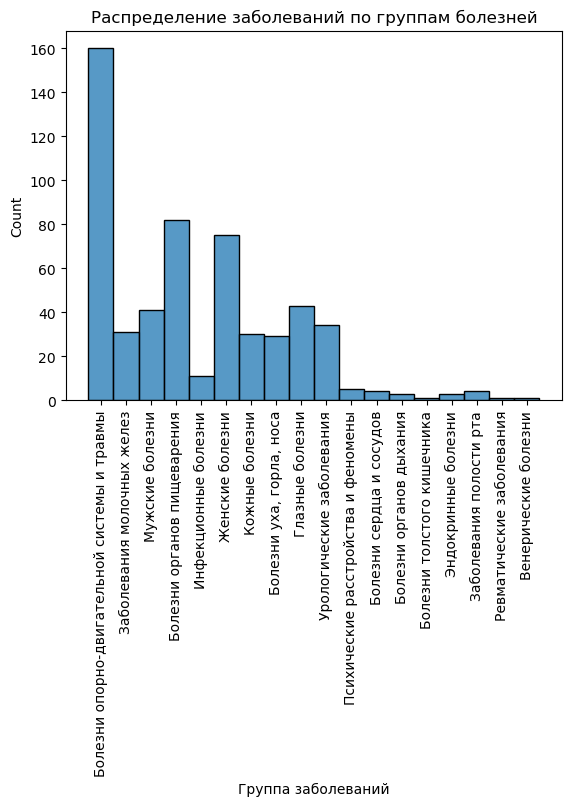

In [24]:
sns.histplot(mine.category)
plt.xticks(rotation=90)
plt.title('Распределение заболеваний по группам болезней')
plt.xlabel('Группа заболеваний')
plt.show()


In [5]:
freq = {}
for row in mine.mpw:
    for i in range(10):
        key, value = row[i]
        if key in freq:
            freq[key] += value
        else:
            freq[key] = value

In [7]:
# most popular words in all diseases
freq_sort = sorted(freq.items(), key=lambda x: x[1], reverse=True)
total_symbols = sum(mine.full_description.str.len())
freq_sort = pd.DataFrame(freq_sort[:10], columns=['word', 'times'])
freq_sort['%'] = freq_sort['times'] / total_symbols * 100
freq_sort

,word,times,%
0,патологическ,4915,0.098218
1,процесс,3575,0.071440
2,лечен,3174,0.063427
3,заболеван,2393,0.047820
4,состоян,2095,0.041865
5,нарушен,2066,0.041285
6,котор,1569,0.031354
7,пациент,1216,0.024300
8,форм,1110,0.022181
9,расстройств,1107,0.022121


In [8]:
freq_cat = {}
for i, row in mine.iterrows():

    category, mpw = row['category'], row['mpw']
    if category not in freq_cat:
        freq_cat[category] = {}
    for i in range(10):
        key, value = mpw[i]
        if key in freq_cat[category]:
            freq_cat[category][key] += value
        else:
            freq_cat[category][key] = value

In [9]:
categories = freq_cat.keys()
freq_cat_sort = pd.DataFrame()
for cat in categories:
    temp_df = pd.DataFrame(freq_cat).fillna(0).loc[:, cat].sort_values(ascending=False).head(10).reset_index()
    temp_df.columns = ['word', 'times']
    temp_df['category'] = cat
    freq_cat_sort = pd.concat([freq_cat_sort, temp_df], axis=0)

In [57]:
mine = mine.merge(freq_cat_sort.groupby('category', as_index=False)['word'].agg(list).rename(columns={'word': 'category_mpw'}))

In [28]:
# mine.head()
# mine['category_mpw'] = mine.map(lambda cat: freq_cat_sort[freq_cat_sort.category == cat]['word'])
# mine.head()

for i, row in freq_cat_sort.iterrows():
    print(row)
    break

word                                        патологическ
times                                             1627.0
category    Болезни опорно-двигательной системы и травмы
Name: 0, dtype: object


In [25]:
# for cat in categories:
#     # sns.countplot(data=freq_cat_sort[freq_cat_sort.category == cat], y='word', palette = 'Blues_d')
#     sns.histplot(data=freq_cat_sort[freq_cat_sort.category == cat], y='word', x='times')
#     plt.title(cat)
#     plt.show()

In [7]:
# mine.to_csv('MedDataset_2.csv',index=False)
mine = pd.read_csv('parsed/MedDataset_2.csv')
mine['full_description_len'] = mine['full_description'].str.len()
mine['symptoms_len'] = mine['symptoms'].str.len()
mine.head(2)

,target,description,category,reasons,types,symptoms,hards,diagnostics,treatment,profilactics,rehabilitations,full_description,mpw,category_mpw,full_description_len,symptoms_len
0,Абсцесс Броди,Абсцесс Броди — одна из форм хронического осте...,Болезни опорно-двигательной системы и травмы,Возбудители Абсцесса Броди – штаммы стафилокок...,Абсцессы могут быть асептическими и септически...,Абсцесс Броди большеберцовой кости проявляет с...,"Абсцесс Броди, как и другие формы остеомиелита...",Диагностика внутрикостного абсцесса часто затр...,"Как правило, лечение заболевания проводят в ст...",На сегодняшний день не разработано эффективных...,При консервативном лечении особых мер в рамках...,Абсцесс Броди — одна из форм хронического осте...,"[('заболеван', 15), ('абсцесс', 12), ('пациент...","['патологическ', 'перелом', 'лечен', 'процесс'...",7193,656
1,Абсцесс молочной железы,Абсцесс молочной железы – это инфекционное вос...,Заболевания молочных желез,Причины возникновения абсцесса груди следующие:,Классификация абсцессов молочной железы может ...,Как выглядит абсцесс груди – этот вопрос задаю...,Осложнения патологии проявляются в виде следую...,Диагностика заболевания предполагает:\nобщий о...,Лечение абсцесса молочной железы включает:\nан...,Прогноз при абсцессе под грудью может быть сле...,Некоторые способы профилактики субареолярного ...,Абсцесс молочной железы – это инфекционное вос...,"[('абсцесс', 19), ('молочн', 17), ('лечен', 16...","['молочн', 'лечен', 'желез', 'может', 'патолог...",7879,165


In [23]:
print(f'''
Минимальная длина полного описания = {mine['full_description_len'].min()}
Максимальная длина полного описания = {mine['full_description_len'].max()}
Средняя длина полного описания = {int(mine['full_description_len'].mean())}

Минимальная длина симптомов = {mine['symptoms_len'].min()}
Максимальная длина симптомов = {mine['symptoms_len'].max()}
Средняя длина симптомов = {int(mine['symptoms_len'].mean())}
      ''')


Минимальная длина полного описания = 2715
Максимальная длина полного описания = 17385
Средняя длина полного описания = 8968

Минимальная длина симптомов = 37
Максимальная длина симптомов = 7701
Средняя длина симптомов = 1069
      


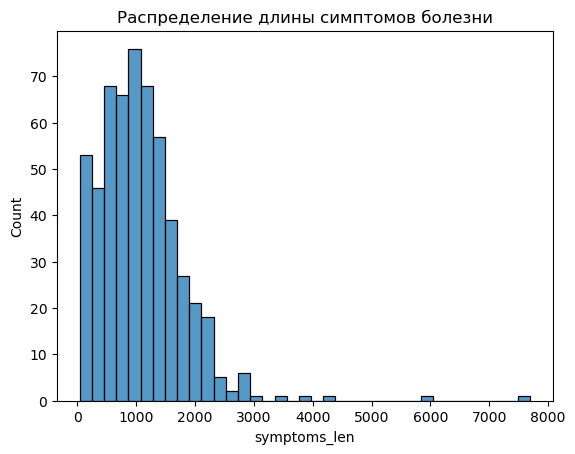

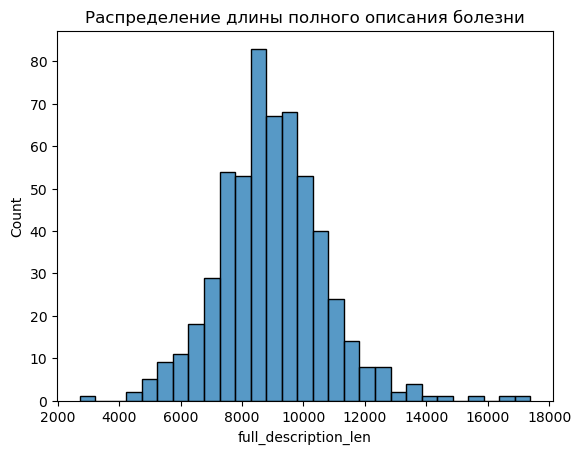

In [15]:
sns.histplot(mine['symptoms_len'])
plt.title('Распределение длины симптомов болезни')
plt.show()
sns.histplot(mine['full_description_len'])
plt.title('Распределение длины полного описания болезни')
plt.show()

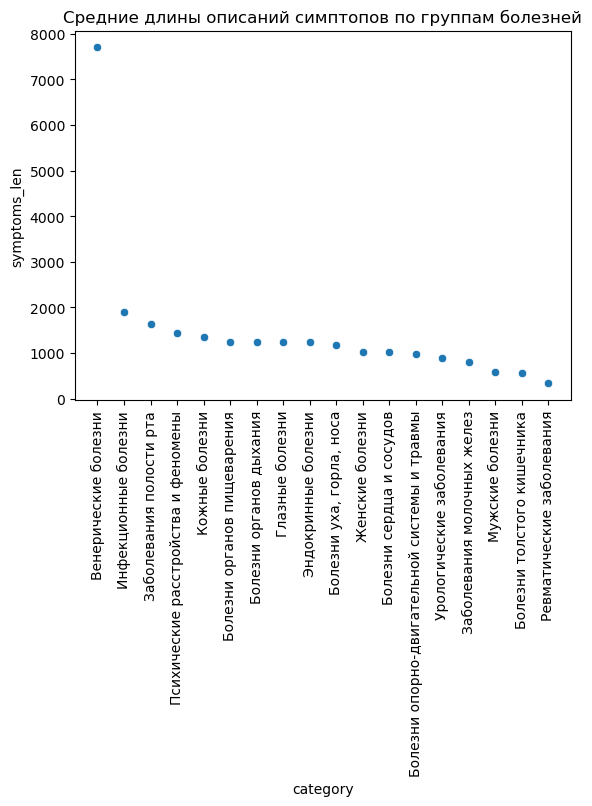

In [35]:
sns.scatterplot(mine.groupby('category').symptoms_len.mean().sort_values(ascending=False))
plt.xticks(rotation=90)
plt.title('Средние длины описаний симптопов по группам болезней')
plt.show()

In [139]:
def extract_ngrams(text, n):
    tokens = word_tokenize(text)
    return list(ngrams(tokens, n))

mine['bigrams'] = mine['full_description'].apply(lambda x: extract_ngrams(x, 2))
mine['trigrams'] = mine['full_description'].apply(lambda x: extract_ngrams(x, 3))

In [29]:
# mine.to_csv('parsed/MedDataset_3.csv')
mine = pd.read_csv('parsed/MedDataset_3.csv')
morph = pymorphy3.MorphAnalyzer()
def pos_frequency(text):
    tokens = word_tokenize(text.lower())  # Токенизируем текст
    pos_tags = [morph.parse(word)[0].tag.POS for word in tokens if morph.parse(word)[0].tag.POS]  # Получаем части речи
    pos_counts = Counter(pos_tags)  # Считаем частоты
    return dict(pos_counts)
mine['pos_symptoms_freq'] = mine['symptoms'].apply(pos_frequency)  # =part_of_speech (часть речи)
mine.head()

,Unnamed: 0,target,description,category,reasons,types,symptoms,hards,diagnostics,treatment,profilactics,rehabilitations,full_description,mpw,category_mpw,full_description_len,symptoms_len,bigrams,trigrams,pos_symptoms_freq
0,0,Абсцесс Броди,Абсцесс Броди — одна из форм хронического осте...,Болезни опорно-двигательной системы и травмы,Возбудители Абсцесса Броди – штаммы стафилокок...,Абсцессы могут быть асептическими и септически...,Абсцесс Броди большеберцовой кости проявляет с...,"Абсцесс Броди, как и другие формы остеомиелита...",Диагностика внутрикостного абсцесса часто затр...,"Как правило, лечение заболевания проводят в ст...",На сегодняшний день не разработано эффективных...,При консервативном лечении особых мер в рамках...,Абсцесс Броди — одна из форм хронического осте...,"[('заболеван', 15), ('абсцесс', 12), ('пациент...","['патологическ', 'перелом', 'лечен', 'процесс'...",7193,656,"[('Абсцесс', 'Броди'), ('Броди', '—'), ('—', '...","[('Абсцесс', 'Броди', '—'), ('Броди', '—', 'од...","{'NOUN': 32, 'VERB': 12, 'ADJF': 12, 'NPRO': 3..."
1,1,Абсцесс молочной железы,Абсцесс молочной железы – это инфекционное вос...,Заболевания молочных желез,Причины возникновения абсцесса груди следующие:,Классификация абсцессов молочной железы может ...,Как выглядит абсцесс груди – этот вопрос задаю...,Осложнения патологии проявляются в виде следую...,Диагностика заболевания предполагает:\nобщий о...,Лечение абсцесса молочной железы включает:\nан...,Прогноз при абсцессе под грудью может быть сле...,Некоторые способы профилактики субареолярного ...,Абсцесс молочной железы – это инфекционное вос...,"[('абсцесс', 19), ('молочн', 17), ('лечен', 16...","['молочн', 'лечен', 'желез', 'может', 'патолог...",7879,165,"[('Абсцесс', 'молочной'), ('молочной', 'железы...","[('Абсцесс', 'молочной', 'железы'), ('молочной...","{'CONJ': 3, 'VERB': 2, 'NOUN': 9, 'ADJF': 5, '..."
2,2,Абсцесс мошонки,Абсцесс мошонки — это острое гнойное воспалени...,Мужские болезни,"Развитие поражения мужской половой системы, мо...",Классификация патологии органа проводится по п...,Абсцесс в паху у мужчин сопровождается выражен...,Осложнения патологического процесса развиваютс...,"Диагностика проводится инструментальными, лабо...","\nЛечение абсцесса строго оперативное, хирург...","Такие состояния, как абсцесс мошонки, опасны в...",NaN,Абсцесс мошонки — это острое гнойное воспалени...,"[('мошонк', 17), ('поражен', 16), ('патологиче...","['лечен', 'состоян', 'полов', 'заболеван', 'др...",9969,711,"[('Абсцесс', 'мошонки'), ('мошонки', '—'), ('—...","[('Абсцесс', 'мошонки', '—'), ('мошонки', '—',...","{'NOUN': 37, 'PREP': 9, 'VERB': 7, 'ADJF': 9, ..."
3,3,Абсцесс мягких тканей,"Абсцесс мягких тканей — это патология, при кот...",Болезни опорно-двигательной системы и травмы,Основной причиной появления абсцесса мягких тк...,Перейдем к описанию подкожного абсцесса мягких...,Основные симптомы начавшегося абсцесса мягких ...,При отсутствии нормального лечения при начавше...,Диагностировать абсцесс мягких тканей можно пр...,В соответствии с полученными рекомендациями ме...,Основные профилактические направления против н...,NaN,"Абсцесс мягких тканей — это патология, при кот...","[('абсцесс', 26), ('ткан', 22), ('мягк', 16), ...","['патологическ', 'перелом', 'лечен', 'процесс'...",7381,1344,"[('Абсцесс', 'мягких'), ('мягких', 'тканей'), ...","[('Абсцесс', 'мягких', 'тканей'), ('мягких', '...","{'ADJF': 30, 'NOUN': 61, 'PRTF': 10, 'PREP': 3..."
4,4,Абсцесс печени,Абсцесс печени (АП) — это образование области ...,Болезни органов пищеварения,Причины абсцесса печени всегда инфекционные ил...,Классификация абсцессов печени может проводить...,Симптомы расстройстваЗаболевание отличается кр...,Осложнения абсцесса печени касаются смертоносн...,Диагностикой патологического процесса занимают...,Лечение абсцесса печени зачастую оперативное. ...,При единичном абсцессе и своевременно лечении ...,Профилактика включает лечение болезней брюшной...,Абсцесс печени (АП) — это образование области ...,"[('абс

In [65]:
mine['pos_full_description_freq'] = mine['full_description'].apply(pos_frequency)

In [25]:
rus_dict = {
    'NOUN': 'Существительное',
    'VERB': 'Глагол',
    'ADJF': 'Прилагательное (полное)',
    'NPRO': 'Местоимение',
    'PREP': 'Предлог',
    'NUMR': 'Числительное',
    'ADVB': 'Наречие',
    'PRCL': 'Частица',
    'CONJ': 'Союз',
    'INFN': 'Инфинитив',
    'PRTF': 'Полное причастие',
    'ADJS': 'Прилагательное (краткое)',
    'PRTS': 'Причастие (краткое)',
    'GRND': 'Деепричастие',
    'INTJ': 'Междометие',
    'COMP': 'Сравнительная степень прилагательных или наречий',
    'PRED': 'Предикатив'
}

In [66]:
def get_rus_pos(row):
    dct = dict(row)
    return {rus_dict[key]: value for key, value in dct.items()}

mine['pos_symptoms_freq_rus'] = mine['pos_symptoms_freq'].apply(get_rus_pos)  # перевод частей речи на русский
mine['pos_full_description_freq_rus'] = mine['pos_full_description_freq'].apply(get_rus_pos)  # перевод частей речи на русский

In [67]:
mine.head(1)

,target,description,category,reasons,types,symptoms,hards,diagnostics,treatment,profilactics,...,mpw,category_mpw,full_description_len,symptoms_len,bigrams,trigrams,pos_symptoms_freq,pos_symptoms_freq_rus,pos_full_description_freq,pos_full_description_freq_rus
0,Абсцесс Броди,Абсцесс Броди — одна из форм хронического осте...,Болезни опорно-двигательной системы и травмы,Возбудители Абсцесса Броди – штаммы стафилокок...,Абсцессы могут быть асептическими и септически...,Абсцесс Броди большеберцовой кости проявляет с...,"Абсцесс Броди, как и другие формы остеомиелита...",Диагностика внутрикостного абсцесса часто затр...,"Как правило, лечение заболевания проводят в ст...",На сегодняшний день не разработано эффективных...,...,"[('заболеван', 15), ('абсцесс', 12), ('пациент...","['патологическ', 'перелом', 'лечен', 'процесс'...",7193,656,"[('Абсцесс', 'Броди'), ('Броди', '—'), ('—', '...","[('Абсцесс', 'Броди', '—'), ('Броди', '—', 'од...","{'NOUN': 32, 'VERB': 12, 'ADJF': 12, 'NPRO': 3...","{'Существительное': 32, 'Глагол': 12, 'Прилага...","{'NOUN': 357, 'VERB': 84, 'ADJF': 120, 'PREP':...","{'Существительное': 357, 'Глагол': 84, 'Прилаг..."


In [85]:
most_popular_POS_fd = {}
for row in mine['pos_full_description_freq_rus']:
    dct = dict(row)
    for key, value in dct.items():
        if key in most_popular_POS_fd:
            most_popular_POS_fd[key] += value
        else:
            most_popular_POS_fd[key] = value
most_popular_POS_fd = pd.DataFrame([most_popular_POS_fd.keys(), most_popular_POS_fd.values()]).T
most_popular_POS_fd.columns=['part_of_speech', 'times']
most_popular_POS_fd = most_popular_POS_fd.sort_values(by='times', ascending=False)
print("Наиболее популярные части речи у \'Полного описания\':")
most_popular_POS_fd    

Наиболее популярные части речи у 'Полного описания':


,part_of_speech,times
0,Существительное,249870
2,Прилагательное (полное),103762
3,Предлог,60161
1,Глагол,47088
9,Союз,39694
5,Наречие,22943
8,Инфинитив,16319
13,Частица,14199
7,Местоимение,7754
4,Полное причастие,6873


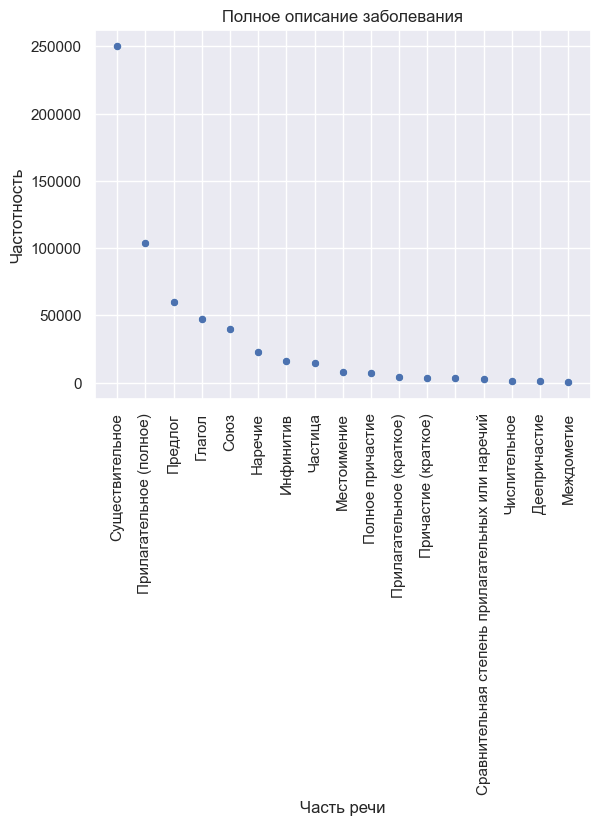

In [99]:
sns.set()
sns.scatterplot(data=most_popular_POS_fd, x='part_of_speech', y='times')
plt.xticks(rotation=90)
plt.xlabel('Часть речи')
plt.ylabel('Частотность')
plt.title('Полное описание заболевания')
plt.show()

In [87]:
most_popular_POS_sympt = {}
for row in mine['pos_symptoms_freq_rus']:
    dct = dict(row)
    for key, value in dct.items():
        if key in most_popular_POS_sympt:
            most_popular_POS_sympt[key] += value
        else:
            most_popular_POS_sympt[key] = value
most_popular_POS_sympt = pd.DataFrame([most_popular_POS_sympt.keys(), most_popular_POS_sympt.values()]).T
most_popular_POS_sympt.columns=['part_of_speech', 'times']
most_popular_POS_sympt = most_popular_POS_sympt.sort_values(by='times', ascending=False)
print("Наиболее популярные части речи у \'Симптомов\':")
most_popular_POS_sympt    

Наиболее популярные части речи у 'Симптомов':


,part_of_speech,times
0,Существительное,28918
2,Прилагательное (полное),12524
4,Предлог,7619
1,Глагол,6636
8,Союз,4542
6,Наречие,3681
7,Частица,2039
10,Инфинитив,1785
3,Местоимение,1006
11,Полное причастие,762


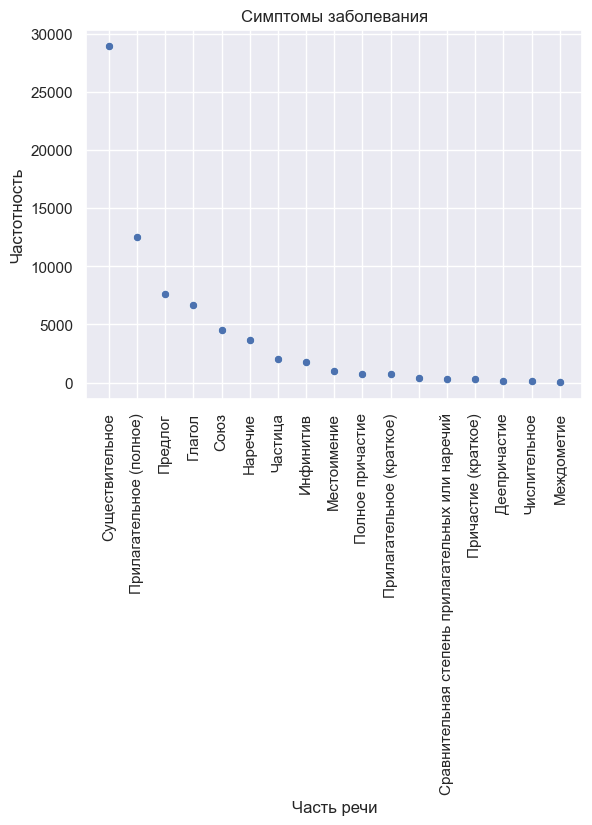

In [100]:
sns.scatterplot(data=most_popular_POS_sympt, x='part_of_speech', y='times')
plt.xticks(rotation=90)
plt.xlabel('Часть речи')
plt.ylabel('Частотность')
plt.title('Симптомы заболевания')
plt.show()

In [102]:
mine.to_csv('parsed/MedDataset_4.csv', index=False)

In [154]:
mine = pd.read_csv('parsed/MedDataset_5.csv')

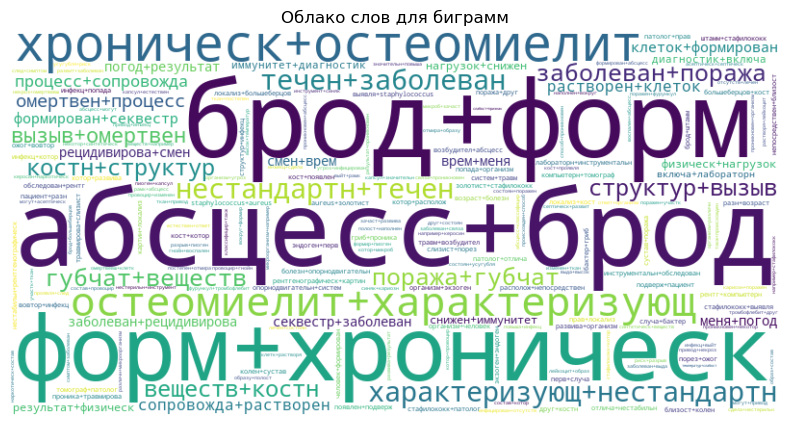

In [143]:
from wordcloud import WordCloud

bigram_freq = {}
for row in mine.bigrams:
    listed_row = eval(row)
    for elem in listed_row:
        if elem not in bigram_freq:
            bigram_freq['+'.join(elem)] = 0
        bigram_freq['+'.join(elem)] += 1

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq)

# Отображение
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для биграмм')
plt.show()

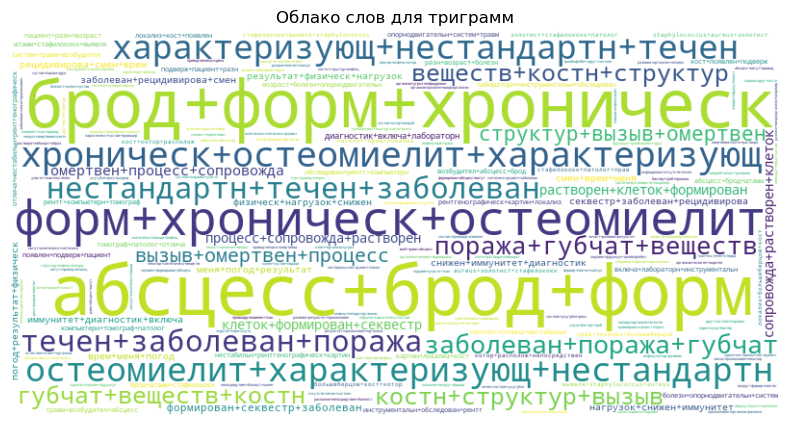

In [151]:
from wordcloud import WordCloud

trigram_freq = {}
for row in mine.trigrams:
    listed_row = eval(row)
    for elem in listed_row:
        if elem not in trigram_freq:
            trigram_freq['+'.join(elem)] = 0
        trigram_freq['+'.join(elem)] += 1

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigram_freq)

# Отображение
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для триграмм')
plt.show()

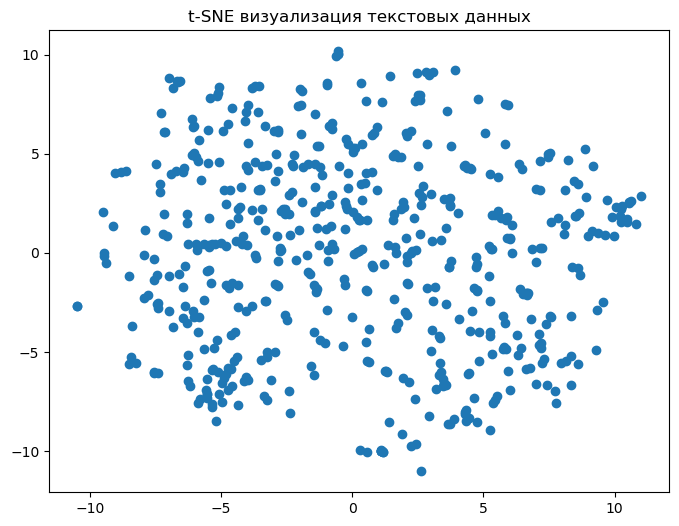

In [152]:
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Пример текстов
texts = mine.symptoms

# Преобразование текстов в числовые векторы с помощью TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts).toarray()

# Опциональное снижение размерности с помощью PCA для ускорения t-SNE
# pca = PCA(n_components=2)  # Снижаем до 50 измерений
# X_pca = pca.fit_transform(X)

# Применение t-SNE для снижения размерности до 2 измерений
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title("t-SNE визуализация текстовых данных")
plt.show()


# Предобработка

In [71]:
text_columns = ['target', 'description', 'category', 'reasons', 'types', 'symptoms',
       'hards', 'diagnostics', 'treatment', 'profilactics', 'rehabilitations',
       'full_description']

In [74]:
# missing values (drop this columns)
print(mine[text_columns].isna().sum())
text_columns.remove('profilactics')
text_columns.remove('rehabilitations')

target               0
description          0
category             0
reasons              1
types                1
symptoms             0
hards                3
diagnostics          4
treatment            6
profilactics        11
rehabilitations     73
full_description     0
dtype: int64


In [76]:
mine[text_columns] = mine[text_columns].fillna('')

In [79]:
mine = mine.drop_duplicates()

In [132]:
import re
from nltk.corpus import stopwords
# nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

total_words = 0
total_non_stop_words = 0
total_stop_words = 0

def preprocess_string(text):
    global total_words, total_non_stop_words, total_stop_words, stop_words
    text = re.sub(r'\d+', '', text)  # -digits
    text = re.sub(r'[^\w\s]', '', text).replace('  ', ' ')  # -symbols
    text = text.lower()
    words = text.split()
    total_words += len(words)
    words = [word for word in words if word not in stop_words]
    total_non_stop_words += len(words)
    total_stop_words = total_words - total_non_stop_words

    stemmer = SnowballStemmer("russian")  # only for rus
    lemmatized_words = [stemmer.stem(word) for word in words]
    lemmatized_words = [word for word in lemmatized_words if len(word) > 3] # hardcode but works
    
    return ' '.join(lemmatized_words)

def clear_data(row):
    for col in text_columns:
        if col != 'target':
            row.loc[col] = preprocess_string(row.loc[col])
    return row

mine = mine.apply(clear_data, axis=1)

In [141]:
# mine.to_csv('parsed/MedDataset_5.csv', index=False)

In [117]:
print(total_words, total_non_stop_words, total_stop_words)  # full_description stats

581676 455757 125919


In [118]:
# perc of stop-words:
print(125919 / 581676 * 100)  # every 5 word

21.647618261712704
